In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Import data

# Total Data
df_total=pd.read_csv('./u.data',sep='\t',header=None,engine='python')

# Training Data
df_train=pd.read_csv('./ua.base',sep='\t',header=None,engine='python')

# Test Data
df_test=pd.read_csv('./ua.test',sep='\t',header=None,engine='python')

In [3]:
num_user=943
num_item=1682

In [4]:
# user-item matrix
def rating_matrix(df):
    R=np.zeros((num_user,num_item))
    df.columns=['user_id','item_id','rating','timestamp']
    for index in range(len(df)):
        u=df['user_id'][index]-1
        i=df['item_id'][index]-1
        R[u,i]=df['rating'][index]
    return R

In [5]:
# preference matrix
def preference_matrix(R):
    P=np.zeros((num_user,num_item))
    for i in range(num_user):
        for j in range(num_item):
            if R[i,j]>0:
                P[i,j]=1
    return P

In [7]:
# Transform dataframe to matrix
R_train=rating_matrix(df_train) # Training Data
P_train=preference_matrix(R_train) # Training Data

R_test=rating_matrix(df_test) # Test Data
P_test=preference_matrix(R_test) # Test Data

R_total=rating_matrix(df_total) # Total Data
P_total=preference_matrix(R_total) # Total Data

In [8]:
# Define set E(u) for evaluation
def E(u):
    E=[(i,j) for i in range(num_item) for j in range(num_item) if (P_test[u,i]!=0)&(P_total[u,j]==0)]
    return E

In [17]:
# save set E
E_set=[]

for u in range(num_user):
    E_set.append(E(u))

In [18]:
def AUC(P):
    sum=0
    for u in range(num_user):
        in_sum=0
        for i,j in E_set[u]:
            if P[u,i]>P[u,j]:
                in_sum+=1
        sum+=in_sum/len(E_set[u])
    return sum/num_user        

In [19]:
# Trainig indexes
samples=[(u,i,j) for u in range(num_user) 
         for i in range(num_item) 
         for j in range(num_item) 
         if (P_train[u,i]==1)&(P_train[u,j]==0)]

In [70]:
# initial values
auc_bpr=[]
K=30 # number of latent factors
P=np.random.random_sample((num_user,K))/K # user vector
Q=np.random.random_sample((num_item,K))/K # item vector

In [71]:
from math import exp

In [72]:
# training procedure
for epoch in range(10):
    for u,i,j in samples:
        r=P[u,:]@Q[i,:].T-P[u,:]@Q[j,:].T
        if r<=705:
            loss=1.0/(1.0+exp(r))
        else:
            loss=0
        P[u,:]+=0.05*(loss*(Q[i,:]-Q[j,:])-0.0025*P[u,:])
        Q[i,:]+=0.05*(loss*P[u,:]-0.0025*Q[i,:])
        Q[j,:]+=0.05*(-loss*P[u,:]-0.00025*Q[j,:])
    auc_bpr.append(AUC(P@Q.T))

In [73]:
print('AUC of BPR: ',AUC(P@Q.T))

AUC of BPR:  0.5807137815897748


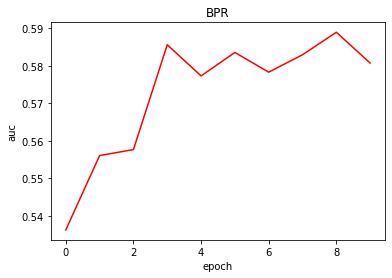

In [74]:
# plot
epoch=[i for i in range(10)]
plt.plot(epoch,auc_bpr,'r') # AUC plot for BPR
plt.xlabel('epoch')
plt.ylabel('auc')
plt.title('BPR')
plt.show()